In [45]:
import config

import os
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

os.chdir(config.DIR_ROOT)

In [36]:
from n02_scripts.n04_create_dataset import create_dataset
from n02_scripts.n05_kmer_statistics import kmer_distribution

# Описание данных

In [3]:
insect_map = pd.read_csv(config.FILE_INSECT_MAP)
insect_map.head()

,name,insect,partition,type,length
0,SVgr_1_id_00001|220,anopheles_albimanus,NaN,NaN,220
1,SVgr_1_id_00003|86,anopheles_albimanus,NaN,NaN,86
2,SVgr_1_id_00005|70,anopheles_albimanus,NaN,NaN,70
3,SVgr_1_id_00009|222,anopheles_albimanus,NaN,NaN,222
4,SVgr_1_id_00018|676,anopheles_albimanus,NaN,NaN,676


In [4]:
insect_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699517 entries, 0 to 1699516
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   name       object 
 1   insect     object 
 2   partition  float64
 3   type       object 
 4   length     int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 64.8+ MB


## Сколько всего последовательностей

In [5]:
len(insect_map)

1699517

## Сколько последовательностей проаннотировано типом

In [6]:
print('Проаннотировано типом:', len(insect_map) - insect_map['type'].isna().sum())
print('Проаннотировано типом (проценты):', (1 - (insect_map['type'].isna().sum() / len(insect_map))) * 100, '%')


Проаннотировано типом: 33457
Проаннотировано типом (проценты): 1.9686181426840643 %


## Сколько последовательностей полностью проаннотированы типом и partition

In [7]:
count_nones = insect_map[insect_map['type'].isna() | insect_map['partition'].isna()].shape[0]
print('Проаннотировано типом и partition:', len(insect_map) - count_nones)
print('Проаннотировано типом и partition (проценты):', (1 - (count_nones / len(insect_map))) * 100, '%')

Проаннотировано типом и partition: 33457
Проаннотировано типом и partition (проценты): 1.9686181426840643 %


## Сколько последовательностей с уникальным partition

In [8]:
insect_map_clean = insect_map.dropna(subset=['type', 'partition'])
unique_pairs_count = insect_map_clean[['partition', 'insect']].drop_duplicates().shape[0]
print('Число уникальных partition', unique_pairs_count)
print('Число уникальных partition (проценты)', (unique_pairs_count / len(insect_map_clean)) * 100, '%')

Число уникальных partition 3108
Число уникальных partition (проценты) 9.289535822100008 %


## Распределение количества последовательностей с определенным типом

### Уникальные значения

In [9]:
unique_types = insect_map_clean['type'].unique()
print(unique_types)

types_distribution_df = insect_map_clean['type'].value_counts().reset_index()
types_distribution_df.columns = ['type', 'count']

total = len(insect_map_clean)
types_distribution_df['percent'] = (types_distribution_df['count'] / total * 100).round(2)

print(types_distribution_df)

['cacta' 'gypsy' 'line' 'copia' 'hat' 'l1' 'helitron' 'mudr']
       type  count  percent
0      line  15307    45.75
1     gypsy   8466    25.30
2        l1   5869    17.54
3     copia   1547     4.62
4       hat   1028     3.07
5  helitron    733     2.19
6     cacta    284     0.85
7      mudr    223     0.67


In [10]:
naming_dict = {'line': 'line',
 'l1': 'line',
 'gypsy': 'gypsy',
 'copia': 'gypsy',
 'mudr': 'mudr',
 'hat': 'mudr',
 'cacta': 'mudr',
 'helitron': 'helitron'}

In [11]:
insect_map_correct_types = insect_map_clean.copy()
insect_map_correct_types['type'] = insect_map_correct_types['type'].map(naming_dict).fillna(insect_map_correct_types['type'])

In [12]:
types_distribution_df = insect_map_correct_types['type'].value_counts().reset_index()
types_distribution_df.columns = ['type', 'count']

total = len(insect_map_correct_types)
types_distribution_df['percent'] = (types_distribution_df['count'] / total * 100).round(2)

print(types_distribution_df)

       type  count  percent
0      line  21176    63.29
1     gypsy  10013    29.93
2      mudr   1535     4.59
3  helitron    733     2.19


## Распреление типов для последовательностей из одного partition

In [13]:
# partition_id - уникальный индентификатор для каждой пары (partition, insect)
insect_unique_partition_id = (
    insect_map_correct_types[["partition", "insect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "partition_id"})
)
insect_unique_partition_id.shape

(3108, 3)

In [14]:
insect_map_correct_types = insect_map_correct_types.merge(
    insect_unique_partition_id,
    on=["partition", "insect"],
    how="right"
)

In [24]:
33457 - 49 - 10-9-9-4-3-2-1-1

33369

In [18]:
type_sets = (
    insect_map_correct_types
    .groupby("partition_id")["type"]
    .apply(lambda x: tuple(sorted(set(x))))
)

type_distribution_counts = type_sets.value_counts()

print(type_distribution_counts)

type
(line,)                    1657
(gypsy,)                   1095
(mudr,)                     224
(gypsy, line)                49
(helitron,)                  44
(gypsy, mudr)                10
(gypsy, line, mudr)           9
(line, mudr)                  9
(gypsy, helitron)             4
(gypsy, helitron, line)       3
(helitron, line)              2
(helitron, mudr)              1
(gypsy, helitron, mudr)       1
Name: count, dtype: int64


## С "развернутым" набором типов

In [19]:
insect_multi_type_unique_partition_id = (
    insect_map_clean[["partition", "insect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "partition_id"})
)
insect_multi_type_unique_partition_id.shape

(3108, 3)

In [20]:
insect_map_clean = insect_map_clean.merge(
    insect_multi_type_unique_partition_id,
    on=["partition", "insect"],
    how="right"
)

In [21]:
type_sets = (
    insect_map_clean
    .groupby("partition_id")["type"]
    .apply(lambda x: tuple(sorted(set(x))))
)

type_distribution_counts = type_sets.value_counts()

print(type_distribution_counts)

type
(line,)                                 1158
(gypsy,)                                 942
(l1,)                                    338
(l1, line)                               161
(copia,)                                 150
(hat,)                                   143
(cacta,)                                  47
(helitron,)                               44
(mudr,)                                   32
(gypsy, line)                             28
(gypsy, l1, line)                         13
(gypsy, l1)                                5
(gypsy, helitron)                          4
(hat, line)                                3
(cacta, gypsy)                             3
(gypsy, helitron, line)                    3
(copia, gypsy)                             3
(gypsy, hat)                               2
(hat, l1)                                  2
(helitron, line)                           2
(gypsy, mudr)                              2
(cacta, mudr)                              2
(copi

### Рассматриваем "сжатые" последовательности, выкидываем "смешенные по типам" partitions

In [27]:
# Оставляем только те строки, где у partition_id ровно один уникальный type
insect_map_unique_type_partition = insect_map_correct_types[
    insect_map_correct_types.groupby("partition_id")["type"]
    .transform("nunique") == 1
]
insect_map_unique_type_partition

,name,insect,partition,type,length,partition_id
0,SVgr_5_id_2735|1344,anopheles_albimanus,6.0,mudr,1344,0
1,SVgr_5_id_2737|1008,anopheles_albimanus,6.0,mudr,1008,0
2,SVgr_1_id_000248|5908,anopheles_arabiensis,6.0,gypsy,5908,1
3,SVgr_1_id_172747|5907,anopheles_arabiensis,6.0,gypsy,5907,1
4,SVgr_1_id_221186|5910,anopheles_arabiensis,6.0,gypsy,5910,1
...,...,...,...,...,...,...
33452,SVgr_7_id_5242|15651,insect_venturia_canescens,52.0,mudr,15651,3105
33453,SVgr_4_id_7720|6451,insect_venturia_canescens,36.0,mudr,6451,3106
33454,SVgr_5_id_3028|21289,insect_venturia_canescens,30.0,mudr,21289,3107
33455,SVgr_5_id_3045|21349,insect_venturia_canescens,30.0,mudr,21349,3107


# Создание датасета

In [30]:
dataset_df = create_dataset(insect_map_unique_type_partition, mode=0, seed=1)

In [31]:
dataset_df

,name,insect,partition,type,length,partition_id
0,SVgr_5_id_2735|1344,anopheles_albimanus,6.0,mudr,1344,0
1,SVgr_2_id_273948|5911,anopheles_arabiensis,6.0,gypsy,5911,1
2,SVgr_1_id_147691|4387,anopheles_arabiensis,7.0,line,4387,2
3,SVgr_2_id_168601|6298,anopheles_arabiensis,9.0,line,6298,3
4,SVgr_2_id_188427|4400,anopheles_arabiensis,14.0,gypsy,4400,4
...,...,...,...,...,...,...
3015,SVgr_2_id_6058|5193,insect_venturia_canescens,49.0,line,5193,3103
3016,SVgr_5_id_3132|13347,insect_venturia_canescens,50.0,gypsy,13347,3104
3017,SVgr_4_id_0142|15093,insect_venturia_canescens,52.0,mudr,15093,3105
3018,SVgr_4_id_7720|6451,insect_venturia_canescens,36.0,mudr,6451,3106


In [53]:
k = 7
dataset_embeddings = pd.DataFrame(columns=["name", "type", "embedding"])

for index, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    insect_name = row['insect']
    sequence_path = os.path.join(config.DIR_GRAPH_PARTITION, f'{insect_name}_seq.fasta')
    rec_sequence = next((r for r in SeqIO.parse(sequence_path, "fasta") if r.id == row['name']), None)
    sequence = str(rec_sequence.seq)
    _, kmer_embedding = kmer_distribution(sequence, k)
    new_row = pd.DataFrame([[row['name'], row['type'], kmer_embedding]],
                       columns=["name", "type", "embedding"])
    dataset_embeddings = pd.concat([dataset_embeddings, new_row], ignore_index=True)

100%|██████████| 3020/3020 [05:38<00:00,  8.91it/s]


In [54]:
dataset_embeddings.shape

(3020, 3)

In [55]:
dataset_embeddings.head

<bound method NDFrame.head of                        name   type  \
0       SVgr_5_id_2735|1344   mudr   
1     SVgr_2_id_273948|5911  gypsy   
2     SVgr_1_id_147691|4387   line   
3     SVgr_2_id_168601|6298   line   
4     SVgr_2_id_188427|4400  gypsy   
...                     ...    ...   
3015    SVgr_2_id_6058|5193   line   
3016   SVgr_5_id_3132|13347  gypsy   
3017   SVgr_4_id_0142|15093   mudr   
3018    SVgr_4_id_7720|6451   mudr   
3019   SVgr_5_id_3045|21349   mudr   

                                              embedding  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.00016934801016088062, 0.0, 0.00016934801016...  
2     [0.0, 0.00022825838849577722, 0.00022825838849...  
3     [0.00270184361093452, 0.0003178639542275906, 0...  
4     [0.0, 0.0, 0.0, 0.0002275830678197542, 0.0, 0....  
...                                                 ...  
3015  [0.0, 0.0, 0.0, 0.0, 0.0, 0.000192789666473877...  
3016  [0.0021737500936961245, 0.00022487069934787

## PCA визуализация

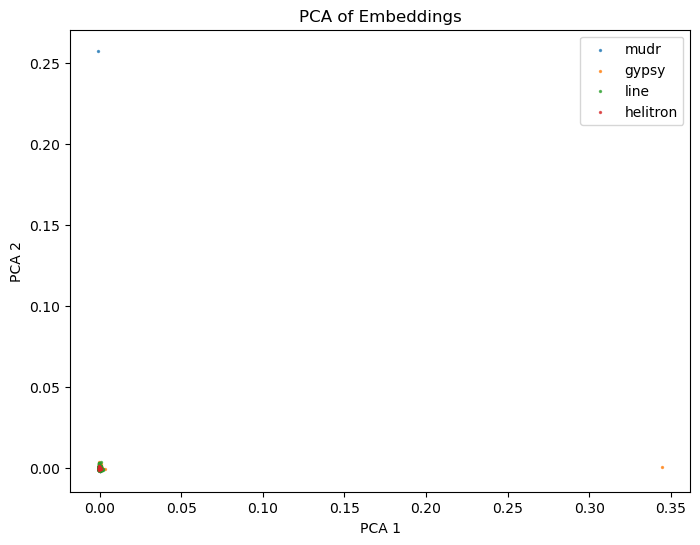

In [56]:
X = np.vstack(dataset_embeddings["embedding"].values)

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Добавим координаты в DataFrame
dataset_embeddings["pca1"] = X_pca[:, 0]
dataset_embeddings["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
for t in dataset_embeddings["type"].unique():
    subset = dataset_embeddings[dataset_embeddings["type"] == t]
    plt.scatter(subset["pca1"], subset["pca2"], label=t, alpha=0.7, s=2)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of Embeddings")
plt.legend()
plt.show()